# Comparaison entre les 2 signaux sur une même fenêtre d'observation

## Importation des librairies nécéssaires

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from datetime import datetime

# Preparation des données

## Importation

In [5]:
data_real = pd.read_csv('./data1.csv', sep=";")
data_real_2 = pd.read_csv('./data2.csv', sep=";")

## Affichage

In [7]:
#  Série 1
data = data_real.iloc[:, [0, 1, 6]].to_numpy()
time_serie = pd.Series(data[:, 2], dtype='float64')
time_serie = time_serie.dropna()

#  Série 2
data2 = data_real_2.iloc[:, [0, 1, 6]].to_numpy()
time_serie2 = pd.Series(data2[:, 2], dtype='float64')
time_serie2 = time_serie2.dropna()

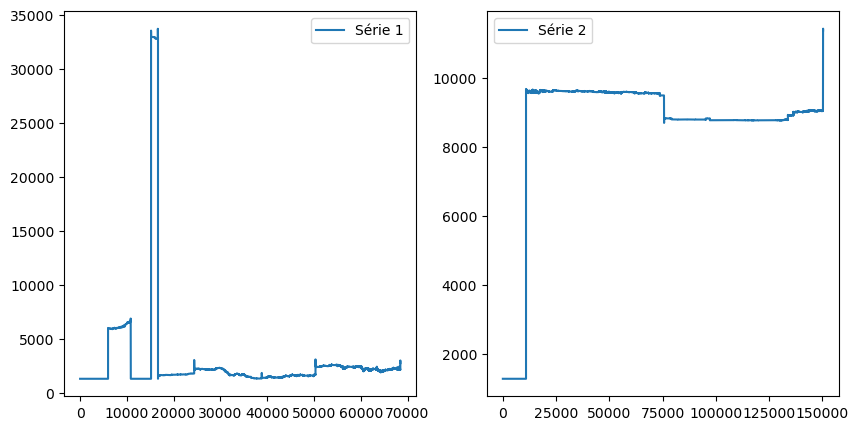

In [9]:
# Affichage des séries
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(time_serie, label='Série 1')
ax[0].legend()
ax[1].plot(time_serie2, label='Série 2')
ax[1].legend()
plt.show()

# Nettoyage des données

Dans le 2e signal, on a avait pu observer que certaines données étaient dupliquées. On va donc commencer par les supprimer.

In [11]:
# Suppression données dupliquées série 2
df_crop = pd.DataFrame(data2)
df_crop = df_crop.drop_duplicates(subset=1, keep='first')

Dates des relevés de la série 1 :  2021.08.05 16:20  -  2021.08.31 23:55
Nombre de données séries 1 :  7580
Dates des relevés de la série 2 :  2021.08.05 16:20  -  2021.08.31 23:55
Nombre de données séries 2 :  7580


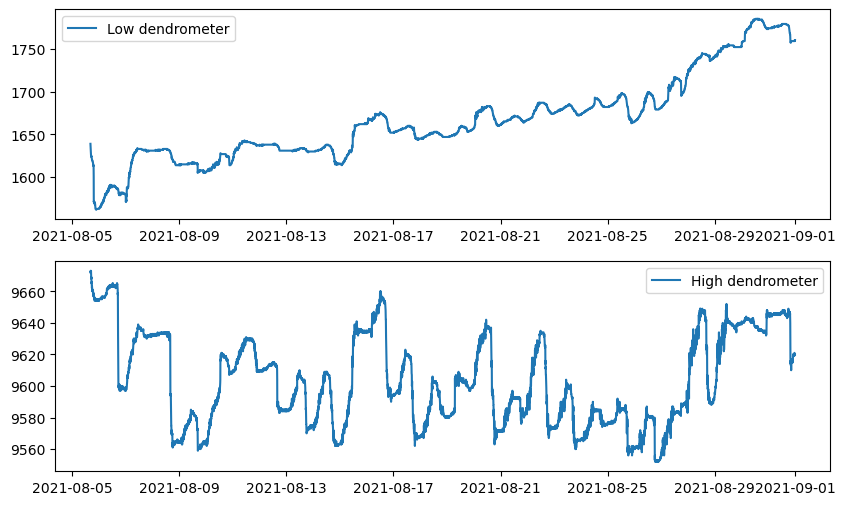

In [13]:
# Fenêtre d'observation série 1
data_crop = data[16656:24236,:] 
time_serie_crop = pd.Series(data_crop[:,2], dtype='float64')

# Fenêtre d'observation série 2
data_crop2 = df_crop.iloc[10884:18464, :].to_numpy()
time_serie_crop2 = pd.Series(data_crop2[:,2], dtype='float64')

# Création de l'axe des abscisses (dates)
data_time = data_crop[:, 1] 
datetime_data = [datetime.strptime(d, "%Y.%m.%d %H:%M") for d in data_time]

# Vérification des fenêtres d'observations
print("Dates des relevés de la série 1 : ", data_crop[0,1], " - ", data_crop[-1,1])
print("Nombre de données séries 1 : ", len(data_crop[:,1]))
print("Dates des relevés de la série 2 : ", data_crop2[0,1], " - ", data_crop2[-1,1])
print("Nombre de données séries 2 : ", len(data_crop2[:,1]))

# Affichage des séries
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(datetime_data,time_serie_crop, label='Low dendrometer')
ax[0].legend()
ax[1].plot(datetime_data,time_serie_crop2, label='High dendrometer')
ax[1].legend()
plt.show()

In [15]:
# Pas de temps de la série 1
data_time = data_real.iloc[16656:24236, 1].to_numpy()
datetime_data = [datetime.strptime(d, "%Y.%m.%d %H:%M") for d in data_time]
differences_minutes = [
    (datetime_data[i] - datetime_data[i-1]).total_seconds() / 60
    for i in range(1, len(datetime_data))
]

print("Différences en minutes entre chaque données pour la série 1:")
print(np.unique(differences_minutes))

# Pas de temps de la série 2
data_time2 = df_crop.iloc[10884:18464, 1].to_numpy()
datetime_data2 = [datetime.strptime(d, "%Y.%m.%d %H:%M") for d in data_time2]
differences_minutes2 = [
    (datetime_data2[i] - datetime_data2[i-1]).total_seconds() / 60
    for i in range(1, len(datetime_data2))
]

print("Différences en minutes entre chaque données pour data 2:")
print(np.unique(differences_minutes2))


Différences en minutes entre chaque données pour la série 1:
[5.]
Différences en minutes entre chaque données pour data 2:
[5.]


# Autocorrélation des signaux

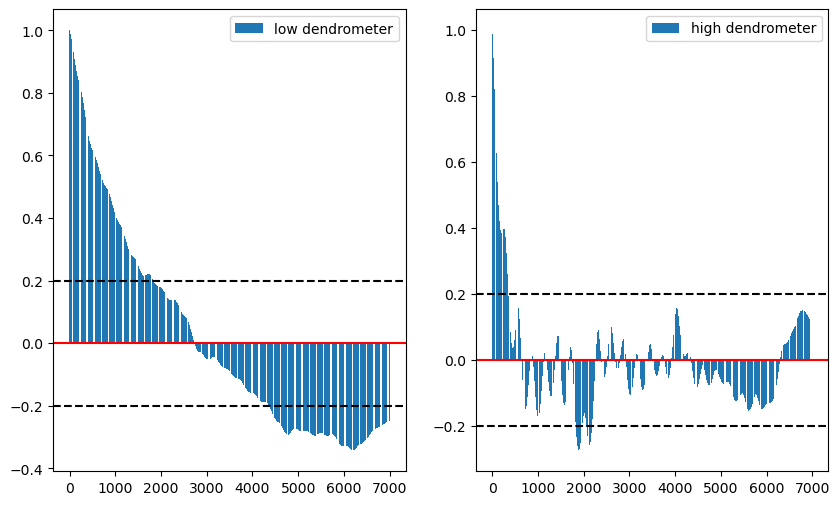

In [17]:
max_lag = 7000
acf_values_1 = sm.tsa.acf(time_serie_crop, nlags = max_lag)
acf_values_2 = sm.tsa.acf(time_serie_crop2, nlags = max_lag)

# Affichage de l'autocorrélation
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].bar(range(max_lag + 1), acf_values_1, label='low dendrometer')
ax[0].axhline(y=0.2, color='black', linestyle='--')
ax[0].axhline(y=0, color='red')
ax[0].axhline(y=-0.2, color='black', linestyle='--')
ax[0].legend()
ax[1].bar(range(max_lag + 1), acf_values_2, label='high dendrometer')
ax[1].axhline(y=0.2, color='black', linestyle='--')
ax[1].axhline(y=0, color='red')
ax[1].axhline(y=-0.2, color='black', linestyle='--')
ax[1].legend()
plt.show()

## Transformée de Fourier

rfft calcule la FFT pour un signal réel, ce qui est plus efficace et donne un résultat simplifié. La FFT transforme le signal data_ajust (une série temporelle) en une série de composantes fréquentielles, exprimées sous forme de nombres complexes.
np.real : Prend la partie réelle de la FFT, ce qui correspond aux amplitudes des composantes fréquentielles, en éliminant la partie imaginaire.

Dans le graphe, on prend la première moitié des fréquences et des amplitudes, car la seconde moitié (au-delà de la fréquence de Nyquist) est symétrique et n'apporte pas d'information nouvelle pour un signal réel.

In [19]:
def freq_to_day (freq) :
    return (1/freq)/(60*24*24)

Période ayant la plus grande amplitude signal 1 : 2.2689176245210727 j
Période ayant la plus grande amplitude signal 2 : 21.93287037037037 j


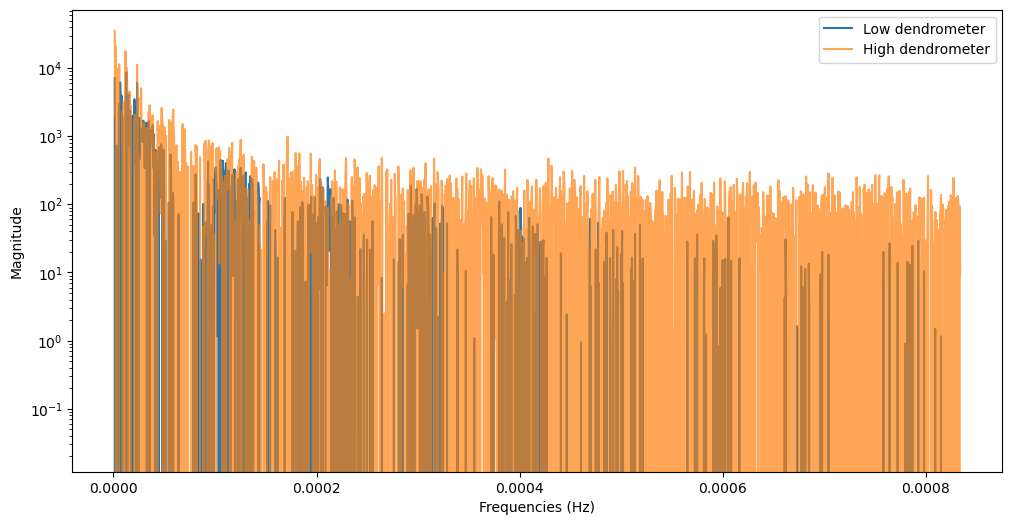

In [38]:
amplitudes1 = np.real(np.fft.rfft(time_serie_crop))[3:] # Les 2 premières sont bizarres
frequencies1 = np.fft.rfftfreq(len(time_serie_crop),5*60)[3:] # 900 = 5*60 : un point tout les 5 min

amplitudes2 = np.real(np.fft.rfft(time_serie_crop2))[3:] # Les 2 premières sont bizarres
frequencies2 = np.fft.rfftfreq(len(time_serie_crop2),5*60)[3:] # 900 = 5*60 : un point tout les 5 min

plt.figure(figsize=(12, 6))
plt.semilogy(frequencies1[:len(frequencies1)//2], amplitudes1[:len(amplitudes1)//2], label='Low dendrometer')
plt.semilogy(frequencies2[:len(frequencies2)//2], amplitudes2[:len(amplitudes2)//2], label='High dendrometer', alpha=0.7)
# Affichage du spectre avec les amplitudes moyennes par bloc
plt.legend()
plt.xlabel('Frequencies (Hz)')
plt.ylabel('Magnitude')
print("Période ayant la plus grande amplitude signal 1 :", freq_to_day(frequencies1[np.argmax(amplitudes1)]),"j" )
print("Période ayant la plus grande amplitude signal 2 :", freq_to_day(frequencies2[np.argmax(amplitudes2)]),"j" )

### Detection harmoniques par peaks

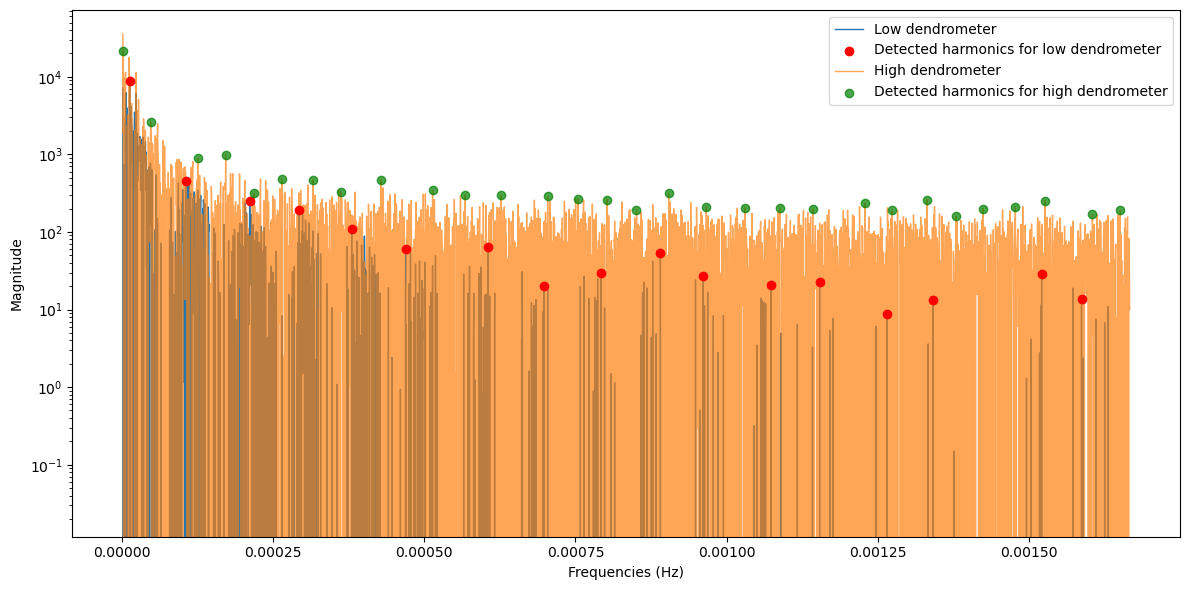

Harmoniques détectées signal 1:
Fréquence : 0.000013 Hz, Fréquence : 2.268918 jours, Amplitude : 8768.55
Harmoniques détectées signal 2:
Fréquence : 0.000002 Hz, Fréquence : 13.159722 jours, Amplitude : 21500.12


In [50]:
from scipy.signal import find_peaks

# Détection des pics
peaks1, properties1 = find_peaks(amplitudes1, prominence=1, distance=150)
peaks2, properties2 = find_peaks(amplitudes2, prominence=1, distance=100)

# Extraction des harmoniques
harmonic_frequencies1 = frequencies1[peaks1]
harmonic_amplitudes1 = amplitudes1[peaks1]
harmonic_frequencies2 = frequencies2[peaks2]
harmonic_amplitudes2 = amplitudes2[peaks2]

# Tracé du spectre et des harmoniques
plt.figure(figsize=(12, 6))

plt.plot(frequencies1, amplitudes1, label='Low dendrometer', linewidth=1)
plt.scatter(harmonic_frequencies1, harmonic_amplitudes1, color='red', label='Detected harmonics for low dendrometer', zorder=5)
plt.plot(frequencies2, amplitudes2, label='High dendrometer', linewidth=1,alpha=0.7)
plt.scatter(harmonic_frequencies2, harmonic_amplitudes2, color='green', alpha=0.7,label='Detected harmonics for high dendrometer', zorder=5)
plt.xlabel('Frequencies (Hz)')
plt.ylabel('Magnitude')
plt.xscale('linear')
plt.yscale('log')  # Échelle logarithmique pour clarifier les pics
plt.legend()
plt.tight_layout()
plt.show()


print("Harmoniques détectées signal 1:")
print(f"Fréquence : {harmonic_frequencies1[0]:.6f} Hz, Fréquence : {freq_to_day(harmonic_frequencies1[0]):.6f} jours, Amplitude : {harmonic_amplitudes1[0]:.2f}")
print("Harmoniques détectées signal 2:")
print(f"Fréquence : {harmonic_frequencies2[0]:.6f} Hz, Fréquence : {freq_to_day(harmonic_frequencies2[0]):.6f} jours, Amplitude : {harmonic_amplitudes2[0]:.2f}")


### Detection harmoniques par moyenne par chunk

In [53]:
def average_by_chunk(frequencies, amplitudes, chunk_size=50):
    # Calcul du nombre de blocs
    num_chunks = len(frequencies) // chunk_size
    avg_frequencies = []
    avg_amplitudes = []
    
    # Diviser en blocs et calculer la moyenne
    for i in range(num_chunks):
        start_idx = i * chunk_size
        end_idx = start_idx + chunk_size
        
        # Sélectionner les indices du bloc
        chunk_frequencies = frequencies[start_idx:end_idx]
        chunk_amplitudes = amplitudes[start_idx:end_idx]
        
        # Calculer la fréquence moyenne (c'est la fréquence du centre du bloc)
        avg_frequency = np.mean(chunk_frequencies)
        
        # Calculer l'amplitude moyenne du bloc
        avg_amplitude = np.mean(chunk_amplitudes)
        
        avg_frequencies.append(avg_frequency)
        avg_amplitudes.append(avg_amplitude)
    
    return np.array(avg_frequencies), np.array(avg_amplitudes)


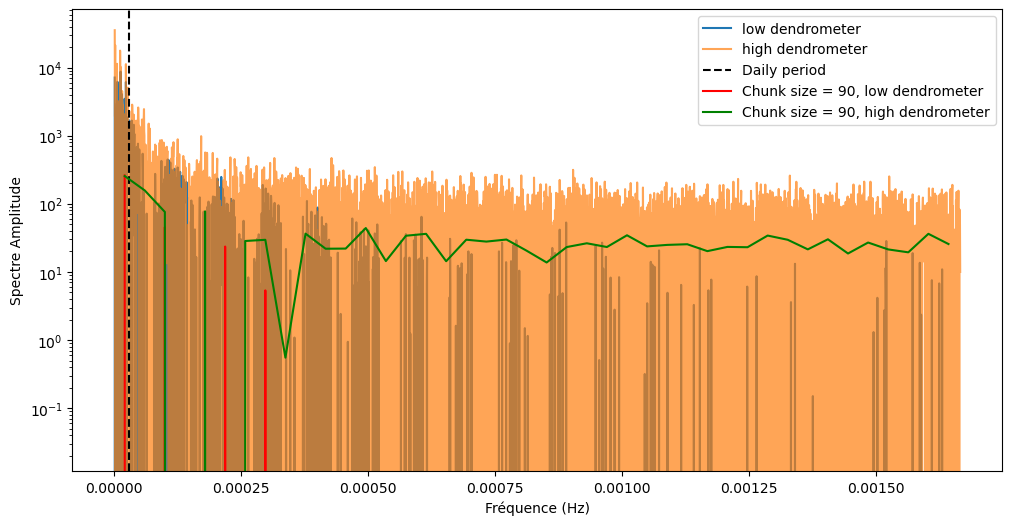

Harmoniques détectées signal 1:
Fréquence : 0.000021 Hz, Fréquence : 1.385234 jours, Amplitude : 261.63
Harmoniques détectées signal 2:
Fréquence : 0.000021 Hz, Fréquence : 1.385234 jours, Amplitude : 256.58


In [63]:
chunk_size = 90
frequencies1_avg_90, amplitudes1_avg_90 = average_by_chunk(frequencies1, amplitudes1, chunk_size)
frequencies2_avg_90, amplitudes2_avg_90 = average_by_chunk(frequencies2, amplitudes2, chunk_size)

plt.figure(figsize=(12, 6))
plt.semilogy(frequencies1, amplitudes1, label='low dendrometer')
plt.semilogy(frequencies2, amplitudes2, label='high dendrometer', alpha=0.7)
plt.axvline(x=1/(60*24*24), color='black', linestyle='--',label='Daily period')
plt.semilogy(frequencies1_avg_90, amplitudes1_avg_90,  label='Chunk size = 90, low dendrometer', color='red')
plt.semilogy(frequencies2_avg_90, amplitudes2_avg_90,  label='Chunk size = 90, high dendrometer', color='green')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Spectre Amplitude')
plt.legend()
plt.show()

print("Harmoniques détectées signal 1:")
print(f"Fréquence : {frequencies1_avg_90[0]:.6f} Hz, Fréquence : {freq_to_day(frequencies1_avg_90[0]):.6f} jours, Amplitude : {amplitudes1_avg_90[0]:.2f}")
print("Harmoniques détectées signal 2:")
print(f"Fréquence : {frequencies2_avg_90[0]:.6f} Hz, Fréquence : {freq_to_day(frequencies2_avg_90[0]):.6f} jours, Amplitude : {amplitudes2_avg_90[0]:.2f}")


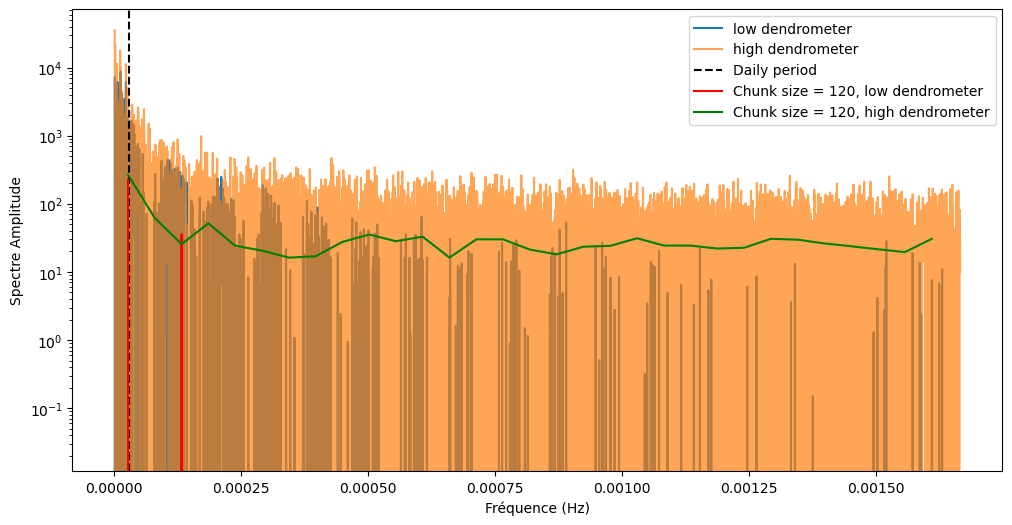

Harmoniques détectées signal 1:
Fréquence : 0.000027 Hz, Fréquence : 1.052778 jours, Amplitude : 224.98
Harmoniques détectées signal 2:
Fréquence : 0.000027 Hz, Fréquence : 1.052778 jours, Amplitude : 267.91


In [65]:
chunk_size = 120
frequencies1_avg_120, amplitudes1_avg_120 = average_by_chunk(frequencies1, amplitudes1, chunk_size)
frequencies2_avg_120, amplitudes2_avg_120 = average_by_chunk(frequencies2, amplitudes2, chunk_size)

plt.figure(figsize=(12, 6))
plt.semilogy(frequencies1, amplitudes1, label='low dendrometer')
plt.semilogy(frequencies2, amplitudes2, label='high dendrometer', alpha=0.7)
plt.axvline(x=1/(60*24*24), color='black', linestyle='--',label='Daily period')
plt.semilogy(frequencies1_avg_120, amplitudes1_avg_120,  label='Chunk size = 120, low dendrometer', color='red')
plt.semilogy(frequencies2_avg_120, amplitudes2_avg_120,  label='Chunk size = 120, high dendrometer', color='green')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Spectre Amplitude')
plt.legend()
plt.show()

print("Harmoniques détectées signal 1:")
print(f"Fréquence : {frequencies1_avg_120[0]:.6f} Hz, Fréquence : {freq_to_day(frequencies1_avg_120[0]):.6f} jours, Amplitude : {amplitudes1_avg_120[0]:.2f}")
print("Harmoniques détectées signal 2:")
print(f"Fréquence : {frequencies2_avg_120[0]:.6f} Hz, Fréquence : {freq_to_day(frequencies2_avg_120[0]):.6f} jours, Amplitude : {amplitudes2_avg_120[0]:.2f}")


## Densité spectrale Welch

In [68]:
from scipy.signal import welch

/opt/anaconda3/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 8192 is greater than input length  = 7580, using nperseg = 7580
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


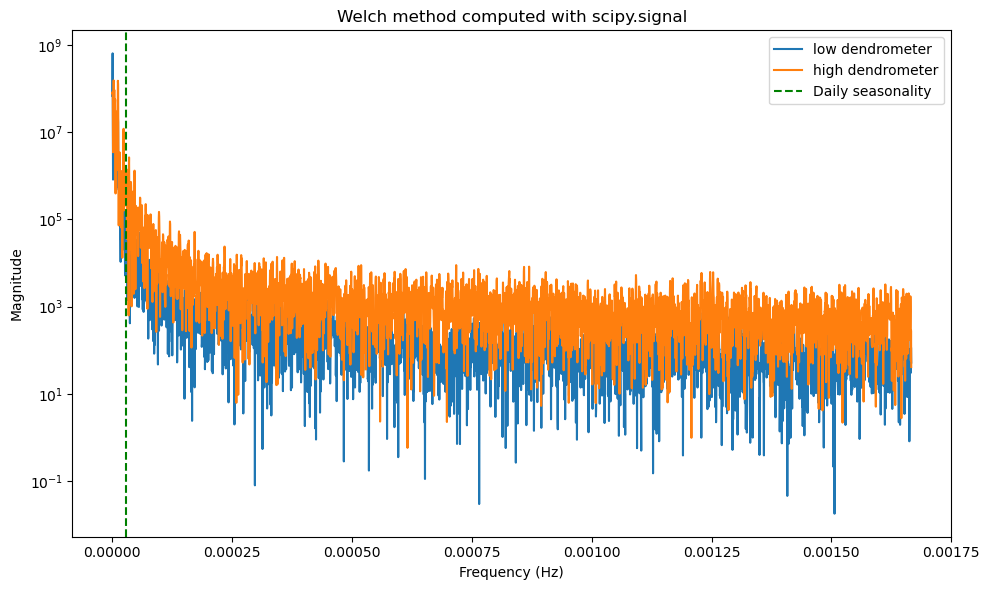

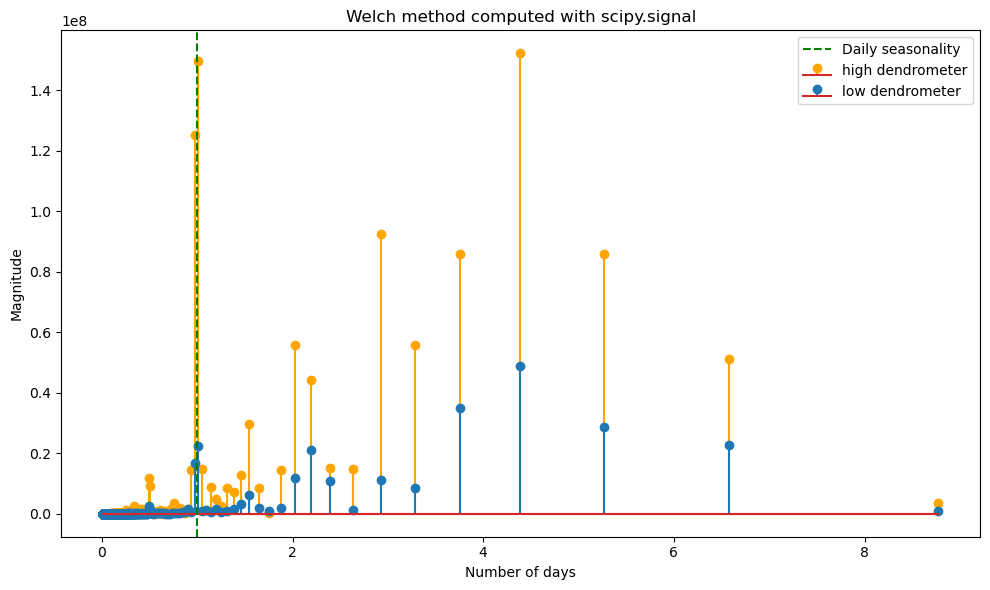

In [112]:
 #Paramètres de la méthode de Welch
nperseg = 8192 # 288
noverlap = int(nperseg/5)
fs = 1 / (60*5)

# Estimation de la PSD avec notre implémentation manuelle de Welch
frequencies_auto1, psd_auto1 = welch(time_serie_crop, fs=fs, nperseg=nperseg , noverlap=noverlap, window="hann", scaling = "density")
frequencies_auto2, psd_auto2 = welch(time_serie_crop2, fs=fs, nperseg=nperseg , noverlap=noverlap, window="hann", scaling = "density")

# Tracé du résultat
plt.figure(figsize=(10, 6))
plt.semilogy(frequencies_auto1, psd_auto1, label="low dendrometer")
plt.semilogy(frequencies_auto2, psd_auto2, label="high dendrometer")
plt.axvline(x=1/(60*24*24), color='green', linestyle='--',label='Daily seasonality')
plt.title('Welch method computed with scipy.signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.stem(((1/frequencies_auto2[3:len(frequencies_auto2)//2])/(60*60*24)), psd_auto2[3:len(psd_auto2)//2], label="high dendrometer", linefmt="orange")
plt.stem(((1/frequencies_auto1[3:len(frequencies_auto1)//2])/(60*60*24)), psd_auto1[3:len(psd_auto1)//2], label="low dendrometer")
plt.axvline(x=1, color='green', linestyle='--',label='Daily seasonality')
plt.title('Welch method computed with scipy.signal')
plt.xlabel('Number of days')
plt.ylabel('Magnitude')
plt.legend()
plt.tight_layout()
plt.show()


In [114]:
max_psd_index1 = np.argmax(np.abs(psd_auto1))
max_psd_frequency1 = frequencies_auto[max_psd_index1]

max_psd_index2 = np.argmax(np.abs(psd_auto2))
max_psd_frequency2 = frequencies_auto[max_psd_index2]


# Afficher la fréquence avec la plus grande PSD
print(f"Fréquence avec la plus grande PSD pour low dendrometer : {(1/max_psd_frequency1)/(60*60*24)} j")
print(f"Fréquence avec la plus grande PSD pour high dendrometer : {(1/max_psd_frequency2)/(60*60*24)} j")

Fréquence avec la plus grande PSD pour low dendrometer : 26.319444444444443 j
Fréquence avec la plus grande PSD pour high dendrometer : 4.386574074074074 j


# Modélisation des séries temporelles

### Modélisation avec la librairie STL

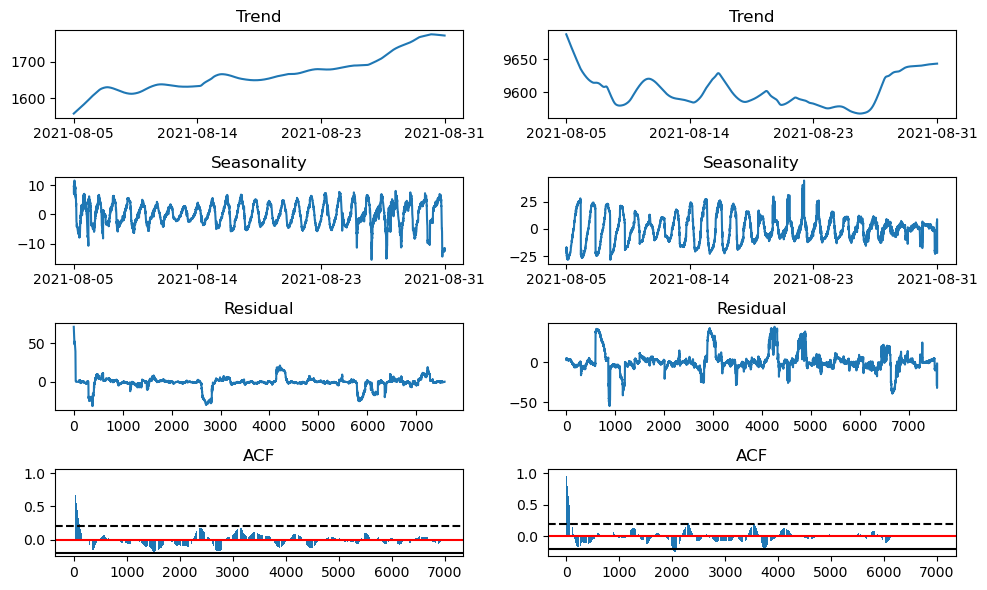

In [140]:
stl1 = STL(time_serie_crop, period=5*60, robust = True)
result_stl1 = stl1.fit()

stl2 = STL(time_serie_crop2, period=5*60, robust = True)
result_stl2 = stl2.fit()

max_lag = 7000
acf_values_1 = sm.tsa.acf(result_stl1.resid, nlags = max_lag)
acf_values_2 = sm.tsa.acf(result_stl2.resid, nlags = max_lag)

fig, ax = plt.subplots(4, 2, figsize=(10, 6))

num_ticks = 4
x_positions = np.linspace(0, len(datetime_data) - 1, num_ticks, dtype=int)
x_labels = [datetime_data[i] for i in x_positions]

ax[0,0].plot(datetime_data,result_stl1.trend)
ax[0,0].set_xticks(x_labels)
ax[0,0].set_title('Trend')
ax[1,0].plot(datetime_data,result_stl1.seasonal)
ax[1,0].set_xticks(x_labels)
ax[1,0].set_title('Seasonality')
ax[2,0].plot(result_stl1.resid)
ax[2,0].set_title('Residual')

ax[0,1].plot(datetime_data,result_stl2.trend)
ax[0,1].set_xticks(x_labels)
ax[0,1].set_title('Trend')
ax[1,1].plot(datetime_data,result_stl2.seasonal)
ax[1,1].set_xticks(x_labels)
ax[1,1].set_title('Seasonality')
ax[2,1].plot(result_stl2.resid)
ax[2,1].set_title('Residual')

ax[3,0].bar(range(max_lag + 1), acf_values_1)
ax[3,0].axhline(y=0.2, color='black', linestyle='--')
ax[3,0].axhline(y=0, color='red')
ax[3,0].axhline(y=-0.2, color='black')
ax[3,0].set_title('ACF')

ax[3,1].bar(range(max_lag + 1), acf_values_2)
ax[3,1].axhline(y=0.2, color='black', linestyle='--')
ax[3,1].axhline(y=0, color='red')
ax[3,1].axhline(y=-0.2, color='black')
ax[3,1].set_title('ACF')

plt.tight_layout()
plt.show()

### Modélisation avec la librairie MSTL

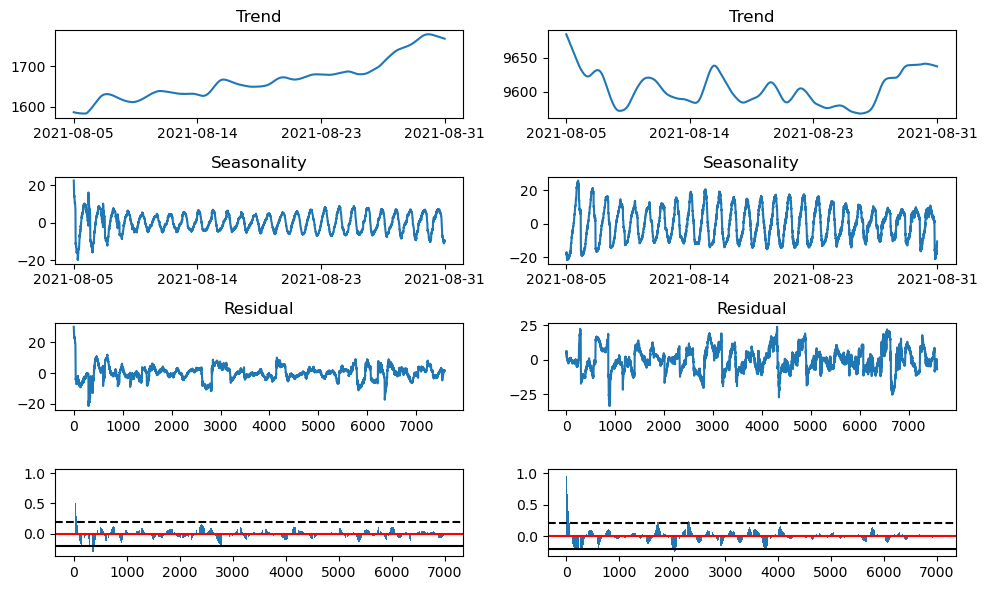

In [142]:
from statsmodels.tsa.seasonal import MSTL

mstl1 = MSTL(time_serie_crop, periods=5*60)
result_mstl1 = mstl1.fit()

mstl2 = MSTL(time_serie_crop2, periods=5*60)
result_mstl2 = mstl2.fit()

max_lag = 7000
acf_values_1 = sm.tsa.acf(result_mstl1.resid, nlags = max_lag)
acf_values_2 = sm.tsa.acf(result_mstl2.resid, nlags = max_lag)

fig, ax = plt.subplots(4, 2, figsize=(10, 6))

ax[0,0].plot(datetime_data,result_mstl1.trend)
ax[0,0].set_xticks(x_labels)
ax[0,0].set_title('Trend')
ax[1,0].plot(datetime_data,result_mstl1.seasonal)
ax[1,0].set_xticks(x_labels)
ax[1,0].set_title('Seasonality')
ax[2,0].plot(result_mstl1.resid)
ax[2,0].set_title('Residual')

ax[0,1].plot(datetime_data,result_mstl2.trend)
ax[0,1].set_xticks(x_labels)
ax[0,1].set_title('Trend')
ax[1,1].plot(datetime_data,result_mstl2.seasonal)
ax[1,1].set_xticks(x_labels)
ax[1,1].set_title('Seasonality')
ax[2,1].plot(result_mstl2.resid)
ax[2,1].set_title('Residual')

ax[3,0].bar(range(max_lag + 1), acf_values_1)
ax[3,0].axhline(y=0.2, color='black', linestyle='--')
ax[3,0].axhline(y=0, color='red')
ax[3,0].axhline(y=-0.2, color='black')

ax[3,1].bar(range(max_lag + 1), acf_values_2)
ax[3,1].axhline(y=0.2, color='black', linestyle='--')
ax[3,1].axhline(y=0, color='red')
ax[3,1].axhline(y=-0.2, color='black')

plt.tight_layout()
plt.show()

### Modélisation avec seasonal_decompose

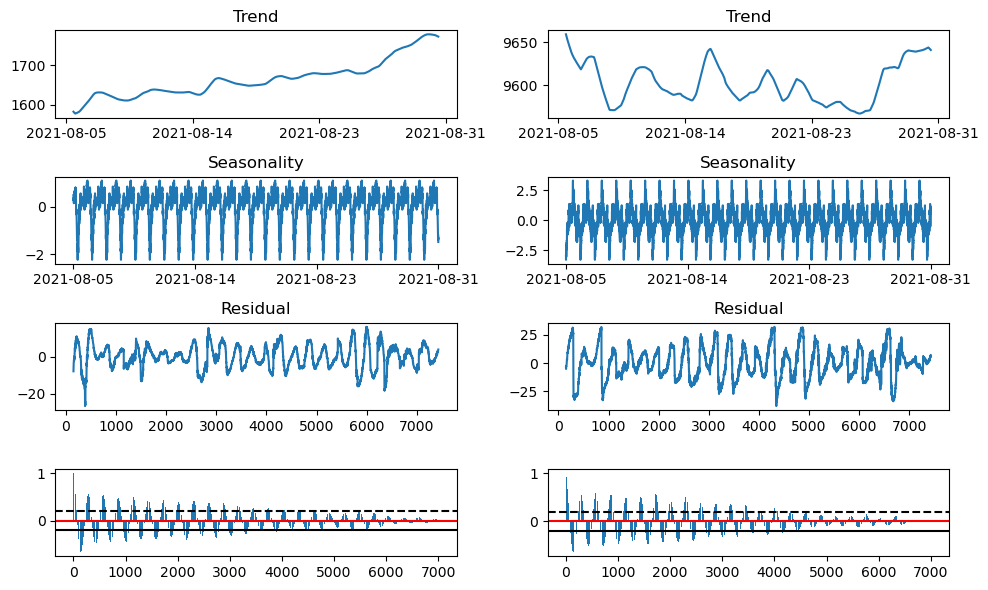

In [144]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_sd1 = seasonal_decompose(time_serie_crop, model='additive', period=60*5)
result_sd2 = seasonal_decompose(time_serie_crop2, model='additive', period=60*5)

max_lag = 7000
acf_values_1 = sm.tsa.acf(result_sd1.resid, nlags = max_lag, missing="drop")
acf_values_2 = sm.tsa.acf(result_sd2.resid, nlags = max_lag, missing="drop")

fig, ax = plt.subplots(4, 2, figsize=(10, 6))

ax[0,0].plot(datetime_data,result_sd1.trend)
ax[0,0].set_xticks(x_labels)
ax[0,0].set_title('Trend')
ax[1,0].plot(datetime_data,result_sd1.seasonal)
ax[1,0].set_xticks(x_labels)
ax[1,0].set_title('Seasonality')
ax[2,0].plot(result_sd1.resid)
ax[2,0].set_title('Residual')

ax[0,1].plot(datetime_data,result_sd2.trend)
ax[0,1].set_xticks(x_labels)
ax[0,1].set_title('Trend')
ax[1,1].plot(datetime_data,result_sd2.seasonal)
ax[1,1].set_xticks(x_labels)
ax[1,1].set_title('Seasonality')
ax[2,1].plot(result_sd2.resid)
ax[2,1].set_title('Residual')

ax[3,0].bar(range(max_lag + 1), acf_values_1)
ax[3,0].axhline(y=0.2, color='black', linestyle='--')
ax[3,0].axhline(y=0, color='red')
ax[3,0].axhline(y=-0.2, color='black')

ax[3,1].bar(range(max_lag + 1), acf_values_2)
ax[3,1].axhline(y=0.2, color='black', linestyle='--')
ax[3,1].axhline(y=0, color='red')
ax[3,1].axhline(y=-0.2, color='black')

plt.tight_layout()
plt.show()

# Analyse de la saisonnalité (périodes et déphasage)

## STL

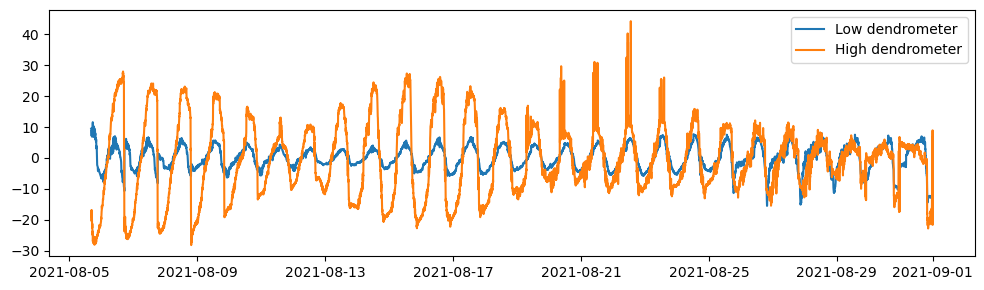

In [43]:
plt.figure(figsize=(10, 3))
plt.plot(datetime_data,result_stl1.seasonal, label = "Low dendrometer")
plt.plot(datetime_data,result_stl2.seasonal, label = "High dendrometer")
plt.legend()
plt.tight_layout()
plt.show()

In [47]:
seasonal1 = result_stl1.seasonal
seasonal2 = result_stl2.seasonal

amplitudes1 = np.real(np.fft.rfft(seasonal1))
frequencies1 = np.fft.rfftfreq(len(seasonal1),5*60) 
amplitudes2 = np.real(np.fft.rfft(seasonal2))
frequencies2 = np.fft.rfftfreq(len(seasonal2),5*60) 

peaks1, _ = scipy.signal.find_peaks(amplitudes1, height=np.mean(amplitudes1) * 0.03)
frequence_principale1 = frequencies1[peaks1[0]] 
periode_principale1 = 1 / frequence_principale1
peaks2, _ = scipy.signal.find_peaks(amplitudes2, height=np.mean(amplitudes2) * 0.03)
frequence_principale2 = frequencies2[peaks2[0]] 
periode_principale2 = 1 / frequence_principale2

print(f"Série 1 --> Fréquence dominante : {frequence_principale1*1e8:.5f} 1e-8 Hz, soit une période d'environ {periode_principale1 / (3600*24):.2f} jours")
print(f"Série 2 --> Fréquence dominante : {frequence_principale2*1e8:.5f} 1e-8 Hz, soit une période d'environ {periode_principale2 / (3600*24):.2f} jours")

Série 1 --> Fréquence dominante : 879.50748 1e-8 Hz, soit une période d'environ 1.32 jours
Série 2 --> Fréquence dominante : 1187.33509 1e-8 Hz, soit une période d'environ 0.97 jours


Déphasage : -20.0 min


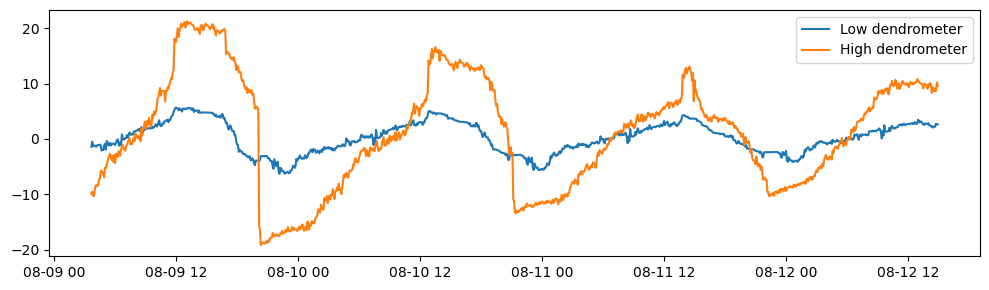

In [51]:
# Détection des pics des deux signaux
peaks1, _ = scipy.signal.find_peaks(seasonal1)
peaks2, _ = scipy.signal.find_peaks(seasonal2)

# Calcul du temps des premiers pics (déphasage temporel)
time_peak1 = datetime_data[peaks1[0]]  # Premier pic du signal 1
time_peak2 = datetime_data[peaks2[0]]  # Premier pic du signal 2

# Déphasage temporel
delta_t = (time_peak2 - time_peak1).total_seconds()

print(f"Déphasage : {delta_t/60:.1f} min")

# Affichage du déphasage
plt.figure(figsize=(10, 3))
plt.plot(datetime_data[1000:2000],result_stl1.seasonal[1000:2000], label = "Low dendrometer")
plt.plot(datetime_data[1000:2000],result_stl2.seasonal[1000:2000], label = "High dendrometer")
plt.legend()
plt.tight_layout()
plt.show()

## MSTL

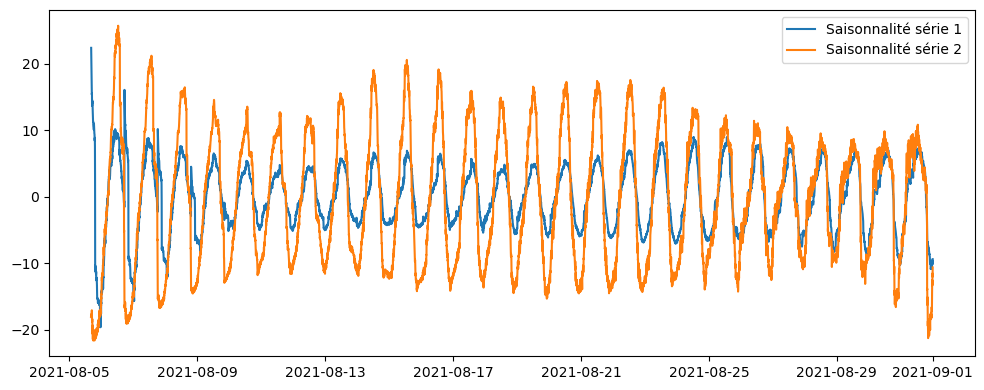

In [40]:
plt.figure(figsize=(10, 4))
plt.plot(datetime_data,result_mstl1.seasonal, label = "Saisonnalité série 1")
plt.plot(datetime_data,result_mstl2.seasonal, label = "Saisonnalité série 2")
plt.legend()
plt.tight_layout()
plt.show()

In [79]:
seasonal1 = result_mstl1.seasonal
seasonal2 = result_mstl2.seasonal

amplitudes1 = np.real(np.fft.rfft(seasonal1))
frequencies1 = np.fft.rfftfreq(len(seasonal1),5*60) 
amplitudes2 = np.real(np.fft.rfft(seasonal2))
frequencies2 = np.fft.rfftfreq(len(seasonal2),5*60) 

peaks1, _ = scipy.signal.find_peaks(amplitudes1, height=np.mean(amplitudes1) * 0.03)
frequence_principale1 = frequencies1[peaks1[0]] 
periode_principale1 = 1 / frequence_principale1
peaks2, _ = scipy.signal.find_peaks(amplitudes2, height=np.mean(amplitudes2) * 0.03)
frequence_principale2 = frequencies2[peaks2[0]] 
periode_principale2 = 1 / frequence_principale2

print(f"Série 1 --> Fréquence dominante : {frequence_principale1*1e8:.5f} 1e-8 Hz, soit une période d'environ {periode_principale1 / (3600*24):.2f} jours")
print(f"Série 2 --> Fréquence dominante : {frequence_principale2*1e8:.5f} 1e-8 Hz, soit une période d'environ {periode_principale2 / (3600*24):.2f} jours")

Série 1 --> Fréquence dominante : 1231.31047 1e-8 Hz, soit une période d'environ 0.94 jours
Série 2 --> Fréquence dominante : 1187.33509 1e-8 Hz, soit une période d'environ 0.97 jours


Déphasage : -25.0 min


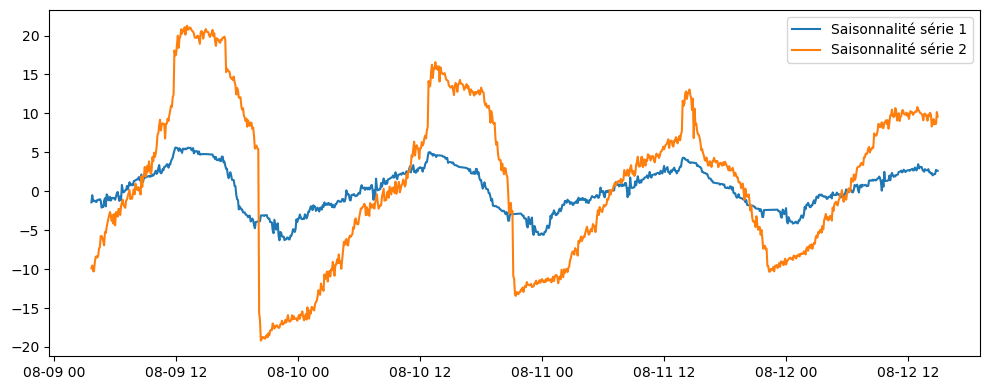

In [81]:
# Détection des pics des deux signaux
peaks1, _ = scipy.signal.find_peaks(seasonal1)
peaks2, _ = scipy.signal.find_peaks(seasonal2)

# Calcul du temps des premiers pics (déphasage temporel)
time_peak1 = datetime_data[peaks1[0]]  # Premier pic du signal 1
time_peak2 = datetime_data[peaks2[0]]  # Premier pic du signal 2

# Déphasage temporel
delta_t = (time_peak2 - time_peak1).total_seconds()

print(f"Déphasage : {delta_t/60:.1f} min")

# Affichage du déphasage
plt.figure(figsize=(10, 4))
plt.plot(datetime_data[1000:2000],result_stl1.seasonal[1000:2000], label = "Saisonnalité série 1")
plt.plot(datetime_data[1000:2000],result_stl2.seasonal[1000:2000], label = "Saisonnalité série 2")
plt.legend()
plt.tight_layout()
plt.show()

## Seasonal Decompose (SD)

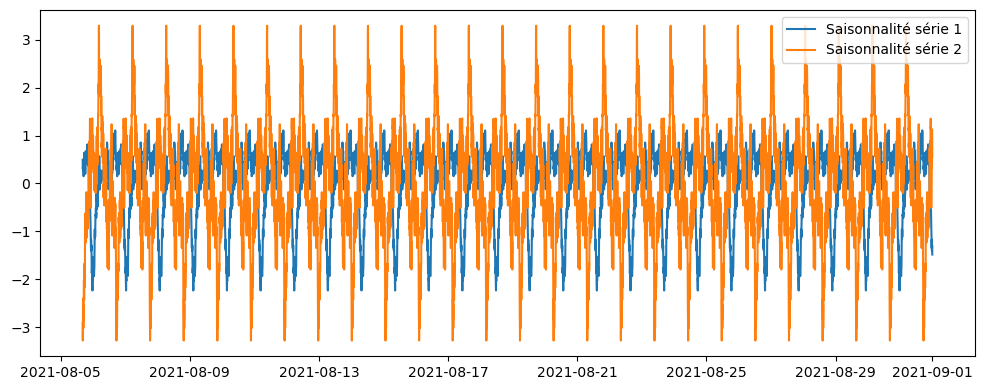

In [45]:
plt.figure(figsize=(10, 4))
plt.plot(datetime_data, result_sd1.seasonal, label = "Saisonnalité série 1")
plt.plot(datetime_data,result_sd2.seasonal, label = "Saisonnalité série 2")
plt.legend()
plt.tight_layout()
plt.show()

In [83]:
seasonal1 = result_sd1.seasonal
seasonal2 = result_sd2.seasonal

amplitudes1 = np.real(np.fft.rfft(seasonal1))
frequencies1 = np.fft.rfftfreq(len(seasonal1),5*60) 
amplitudes2 = np.real(np.fft.rfft(seasonal2))
frequencies2 = np.fft.rfftfreq(len(seasonal2),5*60) 

peaks1, _ = scipy.signal.find_peaks(amplitudes1, height=np.mean(amplitudes1) * 0.03)
frequence_principale1 = frequencies1[peaks1[0]] 
periode_principale1 = 1 / frequence_principale1
peaks2, _ = scipy.signal.find_peaks(amplitudes2, height=np.mean(amplitudes2) * 0.03)
frequence_principale2 = frequencies2[peaks2[0]] 
periode_principale2 = 1 / frequence_principale2

print(f"Série 1 --> Fréquence dominante : {frequence_principale1*1e8:.5f} 1e-8 Hz, soit une période d'environ {periode_principale1 / (3600*24):.2f} jours")
print(f"Série 2 --> Fréquence dominante : {frequence_principale2*1e8:.5f} 1e-8 Hz, soit une période d'environ {periode_principale2 / (3600*24):.2f} jours")

Série 1 --> Fréquence dominante : 1143.35972 1e-8 Hz, soit une période d'environ 1.01 jours
Série 2 --> Fréquence dominante : 1143.35972 1e-8 Hz, soit une période d'environ 1.01 jours


Déphasage : 0.0 min


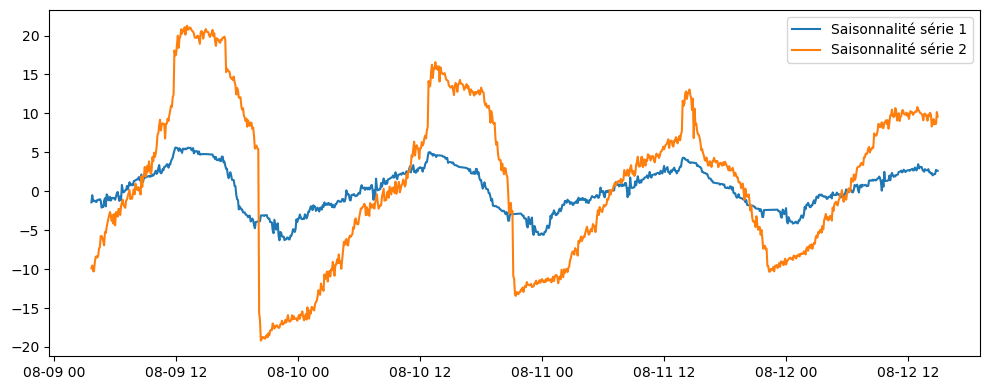

In [85]:
# Détection des pics des deux signaux
peaks1, _ = scipy.signal.find_peaks(seasonal1)
peaks2, _ = scipy.signal.find_peaks(seasonal2)

# Calcul du temps des premiers pics (déphasage temporel)
time_peak1 = datetime_data[peaks1[0]]  # Premier pic du signal 1
time_peak2 = datetime_data[peaks2[0]]  # Premier pic du signal 2

# Déphasage temporel
delta_t = (time_peak2 - time_peak1).total_seconds()

print(f"Déphasage : {delta_t/60:.1f} min")

# Affichage du déphasage
plt.figure(figsize=(10, 4))
plt.plot(datetime_data[1000:2000],result_stl1.seasonal[1000:2000], label = "Saisonnalité série 1")
plt.plot(datetime_data[1000:2000],result_stl2.seasonal[1000:2000], label = "Saisonnalité série 2")
plt.legend()
plt.tight_layout()
plt.show()